# Prediction of the second round presidential elections of 2017.

*Gaspard Michel, Raphaël Gervillié* 

This challenge was done as part of the [Datacamp](https://github.com/x-datascience-datacamp) 2021-2022 course.

![IPP.jpg](https://www.ip-paris.fr/themes/project/img/home/logo_og.jpg)



## Introduction

France, like many countries, operates by the system of universal suffrage. During each vote, 
the results are final when all the votes have finished being counted. But some estimation can be made on the final results during the day. This challenge proposes to explore models allowing to predict the results using only half of the votes. This type of challenge is part of all the economic issues that are seeing a revival with the arrival of machine learning methods. With the increase of available data in open access, it is possible to better model complex economic problems. This challenge therefore aims on the one hand to improve the estimate of the election results and on the other hand to propose an original model allowing to capture the multiple dimensions of this problem.


## Data description

The particularity of the approach comes from the multiple sources of data that are provide for this challenge. We  have the **economic data** at the regional level and at the commune level. These data make it possible to capture the economic situation of a municipality. For example, we have information on the number of businesses, the average tax revenue or the size of the population. All of these factors provide information on voting intentions. The second source of data corresponds to data from **previous elections**. As we are planning the second round, we can use the results of the first round of the presidential elections. Finally, one of the particularity of voting in France comes from its very marked spatial character, this is why we have integrated **spatial data**. To integrate spatial information in our modeling we also provide a graph. Having as node the communes and as link the distance which separates them. We considered that a distance greater than 10km had less influence. Thus there is a link between two municipalities if their distance is less than 10 km. We will see later in this notebook that the spatial dimension plays an important role in modelling.


### Economic data




In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import networkx as nx
import pandas as pd
node_features = pd.read_csv('data/node_features.csv',index_col="node_id",low_memory=False)

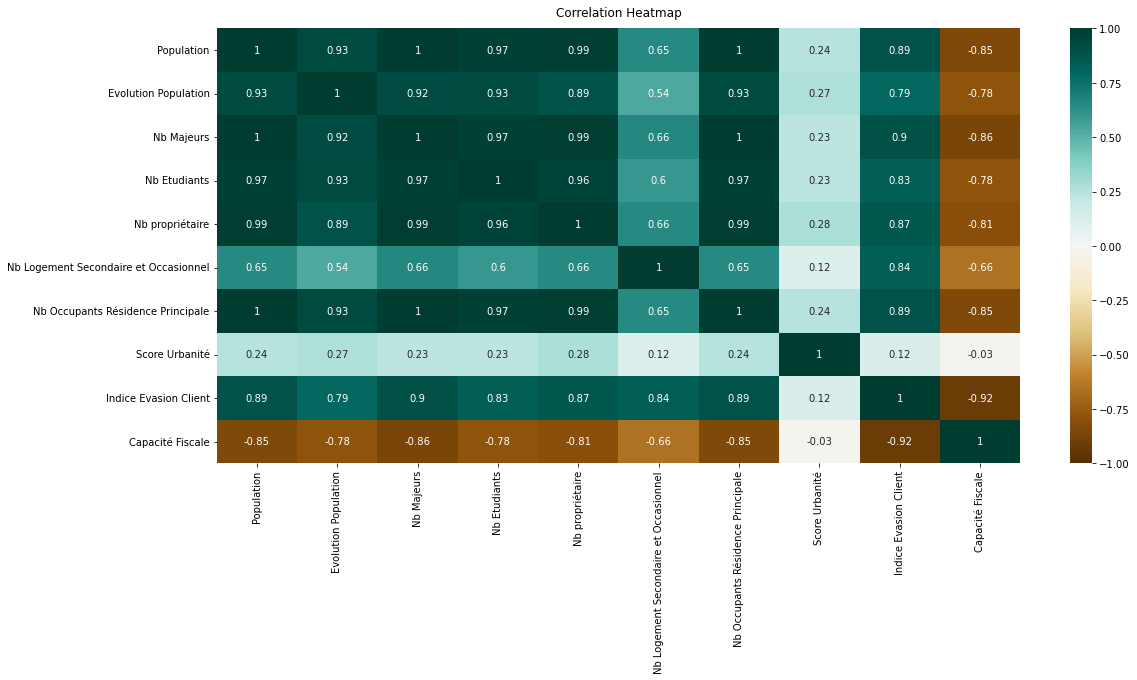

In [20]:
features_elections = ['Inscrits_t2', 'Votants_t2',"Votants_t1",'Abstentions_t1', 'Inscrits_t1', 'Resultat_t1']
features_eco = ['Population','Evolution Population', 'Nb Majeurs', 'Nb Etudiants', 'Nb propriétaire',
'Nb Logement Secondaire et Occasionnel','Nb Occupants Résidence Principale', 'Score Urbanité',
'Indice Evasion Client', 'Capacité Fiscale']
plt.figure(figsize=(18, 8))
heatmap = sns.heatmap(node_features[features_eco].corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Elections

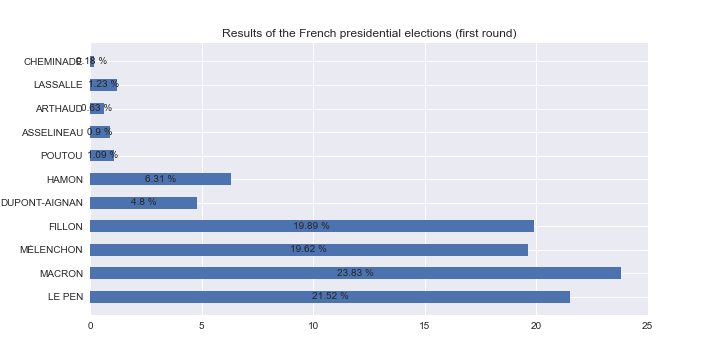

In [36]:
display.Image("data/images/results_t1.png")

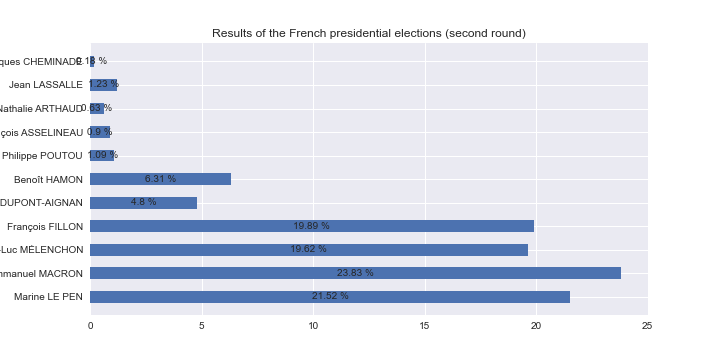

In [35]:
display.Image("data/images/results_t2.png")

## Spatial data

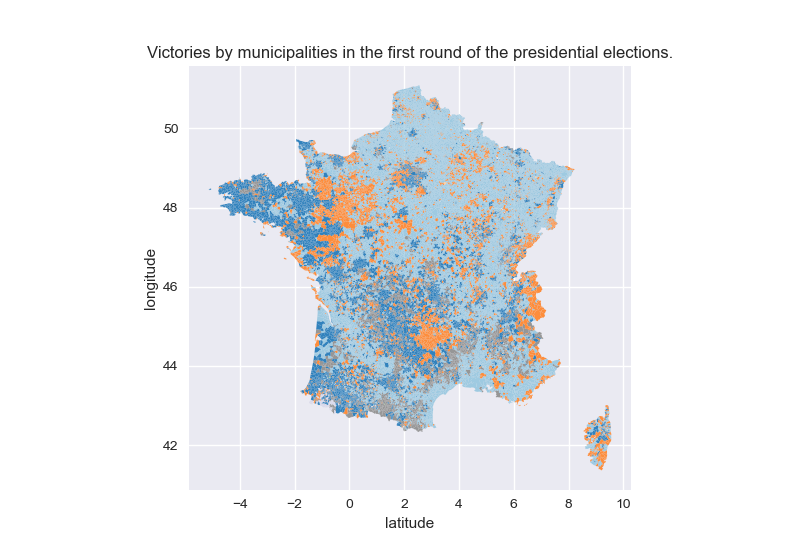

In [34]:
display.Image("data/images/m1.png")

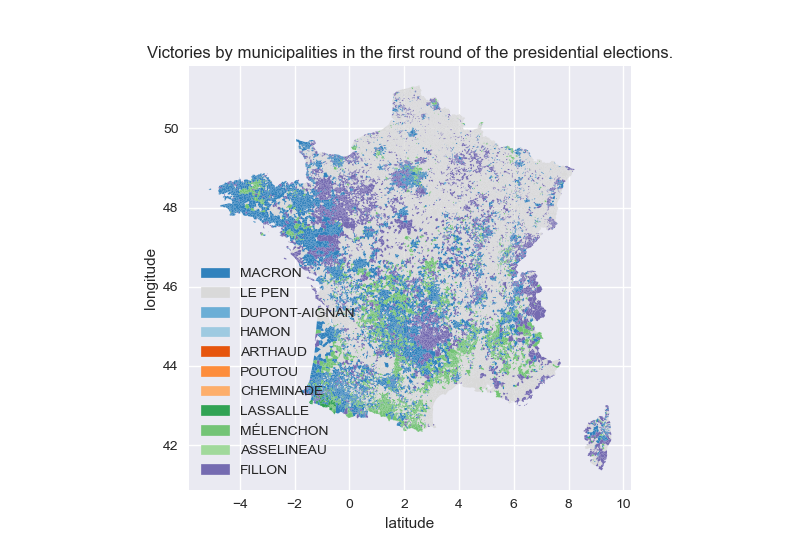

In [33]:
display.Image("data/images/m2.png")

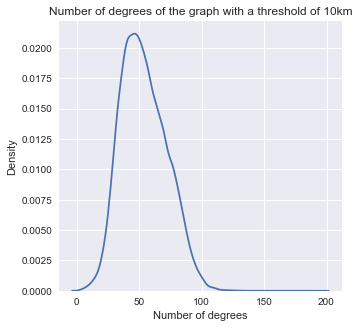

In [32]:
G=nx.read_weighted_edgelist("data/edgelist_dist10000_id")

plt.style.use('seaborn')
g=sns.displot(G.degree,kind="kde")
plt.xlabel("Number of degrees")
plt.ylabel("Density")
plt.title('Number of degrees of the graph with a threshold of 10km')
g._legend.remove()
plt.subplots_adjust(bottom=0.15,top=0.9)